# Goal

Save dset info:
1) list of terminal folders to MR sequences (MPR, T1)

2) metadata df with each folder's sz, sp, dir

3) unique metadat df with unique sz, sp, dir

Notes:
- AVBIB: Patients have repeated scans
    - 403 qualified (slices between 100 and 300, inclusive; seq=MPR or T1)
    - Iso(2): 128,128x115
    - Needs re-orienting
    
- ADNI1: Complete 1YR 1.5T
    - 2294 files, include followups. Perhaps repeats? N3_Scaled and N3_Scaled_2 folders
    - iso2: (141, 141, 110)
    - none disqualified
    - needs re-orienting
    
- AIBL: ADNI-confirmed?
    - iso2 = 128x128x88
    - qualified 1300, disqualified (too small) 8
    
- ICBM: include sequence name GLOBAL? I think its T1
    - iso2 = 128x128x104
    - qualifed: 346, disqualified (too small): 7
    - removed seq: 
        - GLOBAL. Count = 35. 
        - First: ICBM/MNI_0642/GLOBAL/2007-09-08_10_47_04.0/S57327 

    - UNKNOWN. Count = 134. 
         - First: ICBM/UCLA_1558/SAG_DOUBLE_ECHO/2009-08-25_09_48_18.0/S74449 
         
- PPMI: 5 skipped.
    - iso(2) 135x135x120
    - 3271/SAG_FSPGR_3D unknown seq
    - 1362 qualified; disqualified too small 24
    - elongated

# Imports

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# Utilities
import os
import sys
import time
import pickle
from pathlib import Path

# regex
from re import search

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Helper functions
from helpers.dset_info import get_terminal_folders, read_metadata_files, get_unique_df, get_iso_szs, get_range, print_unique, get_ext
from helpers.general   import lrange, sitk2np
from helpers.viz       import viz_axis

# Data Path

Set path to where data is stored.

In [48]:
# NYU
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit"

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

In [49]:
# Paths to (1) code (2) data (3) saved models (4) saved metadata
deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"

# saved models, dset metadata
model_src   = f"{data_src}/saved_models"
save_loc    = f"{data_src}/saved_dset_metadata"

# dsets
dsets_src    = f"{data_src}/PitMRdata"

# print
print("Folders in dset src: ", end=""); print(*os.listdir(dsets_src), sep=", ")

Folders in dset src: ICMB, ABVIB (1).zip, central.xnat.org, ADNI, PPMI, Oasis_long, samir_labels, ACRIN-FMISO-Brain, LGG-1p19qDeletion, REMBRANDT, AIBL, CPTAC-GBM, TCGA-GBM, TCGA-LGG, ABVIB, ABIDE, AIBL.zip


# Load dset files

ABIDE:
- 1157 files

AVBIB: 
- Structure: ABVIB/ABVIB/{number}/{seq}/{date}/{patient_id}/{.dcm files}
- No. MR sequences (terminal folders): 778. No. Unique patients (# top level dir): 276.

ADNI1:
- 639 top-level, 2294 files total but this may be doubled (two version saved, N3 vs N3_2)

AIBL:


In [87]:
# AVBIB Structure: ABVIB/ABVIB/{number}/{seq}/{date}/{patient_id}/{.dcm files}

# key,val = dset_name, path to top level dir
dset_dict = {
    "ABVIB"                  : f"{dsets_src}/ABVIB/ABVIB",
    "ADNI1_Complete_1Yr_1.5T": f"{dsets_src}/ADNI/ADNI1_Complete_1Yr_1.5T/ADNI",
    "AIBL"                   : f"{dsets_src}/AIBL/AIBL",
    "ICMB"                   : f"{dsets_src}/ICMB/ICBM",
    "PPMI"                   : f"{dsets_src}/PPMI/PPMI",
}

dset_name = "PPMI"
dset_src  = dset_dict[dset_name]

print("Folders in dset src: ", end=""); print(len(os.listdir(dset_src)))

Folders in dset src: 745


In [88]:
# if loading from file:
do_load = False
if do_load:
    with open(f"{save_loc}/{dset_name}_dset_metadata.pkl", "rb") as f:
        q_t1 = pickle.load(f)

    with open(f"{save_loc}/{dset_name}_fnames.txt", "rb") as f:
        fnames = pickle.load(f)

In [89]:
# get folders containing .dcm files

# ABIDE:  46.48 s for 1157 files
# ABVIB:  47.35 s for 778 files
# ADNI1_Complete_1Yr_1.5T:  3.78 s for 2294 files
# AIBL: 33.50 s (83 sec) for 1911 files.
# ICBM: 27.09 s for 792 files.
# PPMI: 30.45 s for 1524 files.

# time it
start = time.time()

terminal_folders = get_terminal_folders(dset_src)

elapsed = time.time() - start
print(f"Elapsed {elapsed:.2f} s for {len(terminal_folders)} files.")

Elapsed 30.45 s for 1524 files.


In [90]:
# read metadata

# ABIDE: Elapsed 46.48 s for 1157 files.
# ABVIB: Elapsed 13.42 s for 778 files.
# ADNI1_Complete_1Yr_1.5T: 69.67 s for 2294 files.
# AIBL: 10 sec for 1911 files
# ICBM: 11.66 s for 792 files.
# PPMI:  28.91 s for 1524 files. Exceptions thrown.

# time it
start = time.time()

# read metadata for 1157 paths
qualified, disqualified, skipped = read_metadata_files(terminal_folders)

elapsed = time.time() - start
print(f"Elapsed {elapsed:.2f} s for {len(terminal_folders)} files.")

ERROR. Skipped file below. Exception below.
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/3328/MPRAGE_GRAPPA/2015-01-06_14_09_56.0/S263083/PPMI_3328_MR_MPRAGE_GRAPPA__br_raw_20150612095449655_148_S263083_I497218.dcm
Exception thrown in SimpleITK ImageFileReader_ReadImageInformation: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:105:
sitk::ERROR: Unable to determine ImageIO reader for "/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/3328/MPRAGE_GRAPPA/2015-01-06_14_09_56.0/S263083/PPMI_3328_MR_MPRAGE_GRAPPA__br_raw_20150612095449655_148_S263083_I497218.dcm"
ERROR. Skipped file below. Exception below.
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/4035/MPRAGE_GRAPPA/2017-03-21_12_58_45.0/S606308/PPMI_4035_MR_MPRAGE_GRAPPA__br_raw_20170907130552870_91_S606308_I901224.dcm
Exception thrown in SimpleITK ImageFileReader_ReadImageInformation: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:105:
sitk::ERROR: Unable to determine ImageIO rea

In [95]:
if len(skipped) > 0:
    print(f"Skipped: {len(skipped)}")
    skipped_files, skipped_excep = zip(*skipped)
    print(*[s[len(dset_src):] for s in skipped_files], sep="\n")
    print("\n", "Exceptions", "\n")
    print(*skipped_excep, sep="\n")

Skipped: 5
/3328/MPRAGE_GRAPPA/2015-01-06_14_09_56.0/S263083/PPMI_3328_MR_MPRAGE_GRAPPA__br_raw_20150612095449655_148_S263083_I497218.dcm
/4035/MPRAGE_GRAPPA/2017-03-21_12_58_45.0/S606308/PPMI_4035_MR_MPRAGE_GRAPPA__br_raw_20170907130552870_91_S606308_I901224.dcm
/4034/MPRAGE_GRAPPA_ADNI/2017-03-29_12_48_50.0/S606286/PPMI_4034_MR_MPRAGE_GRAPPA_ADNI_br_raw_20170907125305263_38_S606286_I901198.dcm
/4019/MPRAGE_GRAPPA_ADNI/2016-01-27_13_08_24.0/S405065/PPMI_4019_MR_MPRAGE_GRAPPA_ADNI_br_raw_20160427130941729_101_S405065_I665287.dcm
/4005/MPRAGE_GRAPPA/2013-09-09_11_49_32.0/S205682/PPMI_4005_MR_MPRAGE_GRAPPA__br_raw_20131107164835484_155_S205682_I397644.dcm

 Exceptions 

Exception thrown in SimpleITK ImageFileReader_ReadImageInformation: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:105:
sitk::ERROR: Unable to determine ImageIO reader for "/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/3328/MPRAGE_GRAPPA/2015-01-06_14_09_56.0/S263083/PPMI_3328_MR_MPRAGE_GRAPPA__br_raw

In [97]:
qualified

,fn,imputedSeq,sz,px,sp,dir
0,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,UNKNOWN,"(256, 256, 248)",16-bit signed integer,"(0.98, 0.98, 0.7)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
1,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(288, 288, 170)",16-bit unsigned integer,"(0.92, 0.92, 1.2)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
2,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(240, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
3,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(256, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
4,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(256, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
...,...,...,...,...,...,...
1489,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(240, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
1490,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(256, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
1491,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(256, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
1492,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(256, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"


In [98]:
q_seqs = set(qualified.imputedSeq.values.tolist())
print(q_seqs)

{'T1', 'UNKNOWN', 'MPR'}


In [94]:
unknown_qseqs = [q_seq for q_seq in q_seqs if q_seq not in ("MPR", "T1")]
for q_seq in unknown_qseqs:
    unknown = qualified[qualified["imputedSeq"]==q_seq].fn.values.tolist()
    if len(unknown) > 0:
        print(f"{q_seq}. Count = {len(unknown)}. \n First: {unknown[0]} \n")

UNKNOWN. Count = 132. 
 First: /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/3271/SAG_FSPGR_3D/2011-09-21_12_30_14.0/S124934 



In [99]:
q_t1 = qualified[qualified["imputedSeq"].isin(["MPR", "T1"])]

In [100]:
print(len(q_t1))
q_t1

1362


,fn,imputedSeq,sz,px,sp,dir
1,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(288, 288, 170)",16-bit unsigned integer,"(0.92, 0.92, 1.2)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
2,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(240, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
3,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(256, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
4,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(256, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
5,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(240, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
...,...,...,...,...,...,...
1489,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(240, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
1490,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(256, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
1491,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(256, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
1492,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(256, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"


In [101]:
q_t1.to_pickle(f"{save_loc}/{dset_name}_dset_metadata.pkl")

In [102]:
fnames = q_t1.fn.values.tolist()
with open(f"{save_loc}/{dset_name}_fnames.txt", "wb") as f:
    pickle.dump(fnames, f)

In [103]:
# check extensions
ext = set([get_ext(fn)[0] for fn in fnames])
print(ext)

{'.dcm'}


In [104]:
if len(disqualified) > 0:
    d_t1 = disqualified[disqualified["imputedSeq"].isin(["MPR", "T1"])]
    print(len(d_t1))
    d_fns = d_t1.fn.values
    print(*enumerate(d_fns), sep="\n")
    display(d_t1)
    d_t1.to_pickle(f"{save_loc}/{dset_name}_dset_metadata_DISQUALIFIED.pkl")
else:
    print("none disqualified")

24
(0, '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/3433/SAG_T1_3D_FSPGR/2011-09-27_09_21_23.0/S131890')
(1, '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/3448/SAG_T1_3D_FSPGR/2012-05-23_08_27_49.0/S180310')
(2, '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/3354/MPRAGE_GRAPPA/2015-04-06_08_41_59.0/S263087')
(3, '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/3420/SAG_T1_3D_FSPGR/2011-04-27_14_08_20.0/S139720')
(4, '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/41370/tra_T1_MPRAGE/2016-02-04_10_04_57.0/S405074')
(5, '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/3421/SAG_T1_3D_FSPGR/2011-06-15_08_19_11.0/S113573')
(6, '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/4051/SAG_T1_3D_FSPGR/2012-05-25_08_14_33.0/S178160')
(7, '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/PPMI/PPMI/3422/SAG_T1_3D_FSPGR/2011-06-16_20_00_38.0/S170937')
(8, '/gpfs/data/oermannlab/priva

,fn,imputedSeq,sz,px,sp,dir
0,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,T1,"(256, 256, 88)",16-bit signed integer,"(0.94, 0.94, 1.5)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
1,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,T1,"(256, 256, 94)",16-bit signed integer,"(0.94, 0.94, 1.5)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
2,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(240, 256, 3)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
3,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,T1,"(256, 256, 84)",16-bit signed integer,"(0.94, 0.94, 1.5)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
4,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(256, 256, 67)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(1, 0, 0, 0, 1, 0, 0, 0, 1)"
5,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,T1,"(256, 256, 90)",16-bit signed integer,"(0.94, 0.94, 1.5)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
6,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,T1,"(256, 256, 94)",16-bit signed integer,"(0.94, 0.94, 1.5)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
7,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,T1,"(256, 256, 94)",16-bit signed integer,"(0.94, 0.94, 1.5)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
8,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,MPR,"(240, 256, 96)",16-bit unsigned integer,"(1.05, 1.05, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
9,/gpfs/data/oermannlab/private_data/DeepPit/Pit...,T1,"(256, 256, 98)",16-bit signed integer,"(0.94, 0.94, 1.5)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"


# Unique

In [105]:
unique_df = get_unique_df(q_t1)

In [106]:
print(len(unique_df))
unique_df

61


,sz,sp,dir,fn,cnts
0,"(192, 192, 128)","(1.25, 1.25, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)",/gpfs/data/oermannlab/private_data/DeepPit/Pit...,16
1,"(192, 192, 160)","(1.25, 1.25, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)",/gpfs/data/oermannlab/private_data/DeepPit/Pit...,7
2,"(192, 256, 160)","(0.86, 0.86, 1.0)","(1, 0, 0, 0, 0, 1, 0, -1, 0)",/gpfs/data/oermannlab/private_data/DeepPit/Pit...,1
3,"(216, 256, 208)","(0.9, 0.9, 1.0)","(1, 0, 0, 0, 1, 0, 0, 0, 1)",/gpfs/data/oermannlab/private_data/DeepPit/Pit...,1
4,"(240, 256, 120)","(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)",/gpfs/data/oermannlab/private_data/DeepPit/Pit...,1
...,...,...,...,...,...
56,"(288, 288, 180)","(0.87, 0.87, 0.8)","(1, 0, 0, 0, 1, 0, 0, 0, 1)",/gpfs/data/oermannlab/private_data/DeepPit/Pit...,1
57,"(288, 288, 184)","(0.87, 0.87, 1.2)","(0, 0, -1, 1, 0, 0, 0, -1, 0)",/gpfs/data/oermannlab/private_data/DeepPit/Pit...,2
58,"(320, 320, 175)","(0.72, 0.72, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)",/gpfs/data/oermannlab/private_data/DeepPit/Pit...,1
59,"(448, 448, 170)","(0.54, 0.54, 1.2)","(0, 0, -1, 1, 0, 0, 0, -1, 0)",/gpfs/data/oermannlab/private_data/DeepPit/Pit...,3


In [107]:
print("Directions"); print_unique(unique_df.dir.values.tolist())
print("Sizes"); print_unique(unique_df.sz.values.tolist())
print("Spaces"); print_unique(unique_df.sp.values.tolist())

Directions
******************************
Num unique =  5
Unique:  [ 0  0 -1  0  0  0  0  0  0] [ 0  0 -1  1  0  0  0 -1  0] [1 0 0 0 0 0 0 0 0] [ 1  0  0  0  0  1  0 -1  0] [1 0 0 0 1 0 0 0 1]
Counts:  7 47 1 1 5
Idxs:  [11  0 19  2  3]
******************************
Sizes
******************************
Num unique =  42
Unique:  [192 192 128] [192 192 160] [192 256 160] [216 256 208] [240 256 120] [240 256 144] [240 256 152] [240 256 160] [240 256 174] [240 256 175] [240 256 176] [240 256 192] [248 256 176] [256 240 176] [256 256 100] [256 256 102] [256 256 104] [256 256 106] [256 256 120] [256 256 124] [256 256 132] [256 256 133] [256 256 136] [256 256 142] [256 256 152] [256 256 160] [256 256 162] [256 256 170] [256 256 176] [256 256 192] [256 256 194] [256 256 196] [256 256 239] [256 256 240] [256 256 248] [288 288 160] [288 288 170] [288 288 180] [288 288 184] [320 320 175] [448 448 170] [512 512 130]
Counts:  1 1 1 1 1 2 1 1 1 1 4 2 2 2 1 1 1 2 1 1 1 2 1 1 1 2 2 3 6 2 1 1 1 1 1 1

In [108]:
szs    = unique_df.sz.values.tolist()
max_sz = get_range(szs)

print(max_sz)

# isotropic max size
iso_szs = get_iso_szs(unique_df, 2)
iso_max_sz = get_range(iso_szs)
print(iso_max_sz)

i: 192-512
j: 192-512
k: 100-248
tensor([512, 512, 248])
i: 83-135
j: 110-135
k: 53-120
tensor([135, 135, 120])


# Viz

In [109]:
def read_dcm(fn):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(fn)
    reader.SetFileNames(dicom_names)
    im = reader.Execute() 

    return im

def read_nii(fn):
    mr = sitk.ReadImage(im_path, sitk.sitkFloat32)
    im = torch.transpose(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)
    
def viz_fn(fn, do_reorient=False, do_dcm=False):
    
    # Read fname into np array (dcm or nii)
    if do_dcm:
        im = read_dcm(fn)
    else:
        im = sitk.ReadImage(fn, sitk.sitkFloat32)
    
    # Re-orient to LPI
    if do_reorient:
        orientation_filter = sitk.DICOMOrientImageFilter()
        orientation_filter.SetDesiredCoordinateOrientation("LPS")
        im = orientation_filter.Execute(im)
    
    # Convert to np 
    im = sitk2np(im)
    
    # Select middle 10 slices of each axis
    ranges = [lrange(sh//2-5,sh//2+5) for sh in im.shape]
    
    # Viz
    viz_axis(np_arr = im, \
                slices=ranges[0], fixed_axis=0, \
                axis_fn = np.rot90, \
                title   = "Axis 0", \

                np_arr_b = im, \
                slices_b = ranges[1], fixed_axis_b=1, \
                title_b  = "Axis 1", \

                np_arr_c = im, \
                slices_c = ranges[2], fixed_axis_c=2, \
                title_c = "Axis 2", \

            ncols = 5, hspace=0.3, fig_mult=2, cmap0="gray")

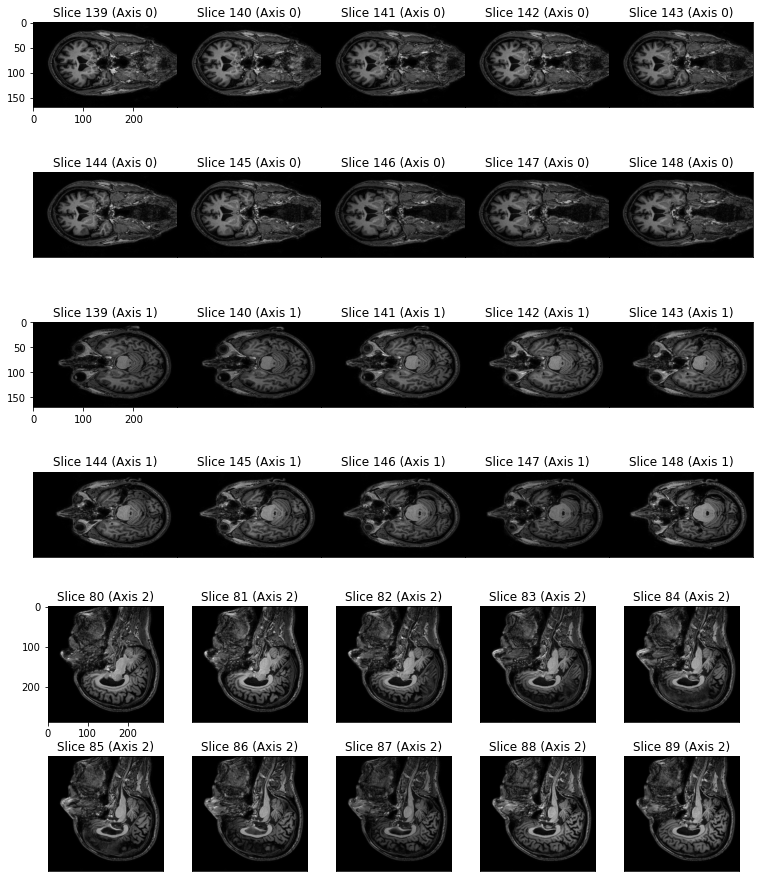

In [110]:
# Not reoriented
if len(ext) == 1 and ".dcm" in ext:
    viz_fn(fnames[0], do_dcm = True, do_reorient=False)
else:
    nii = [f"{fn}/{os.listdir(fn)[0]}" for fn in fnames]
    print(nii[0])
    viz_fn(nii[0], do_reorient=False)

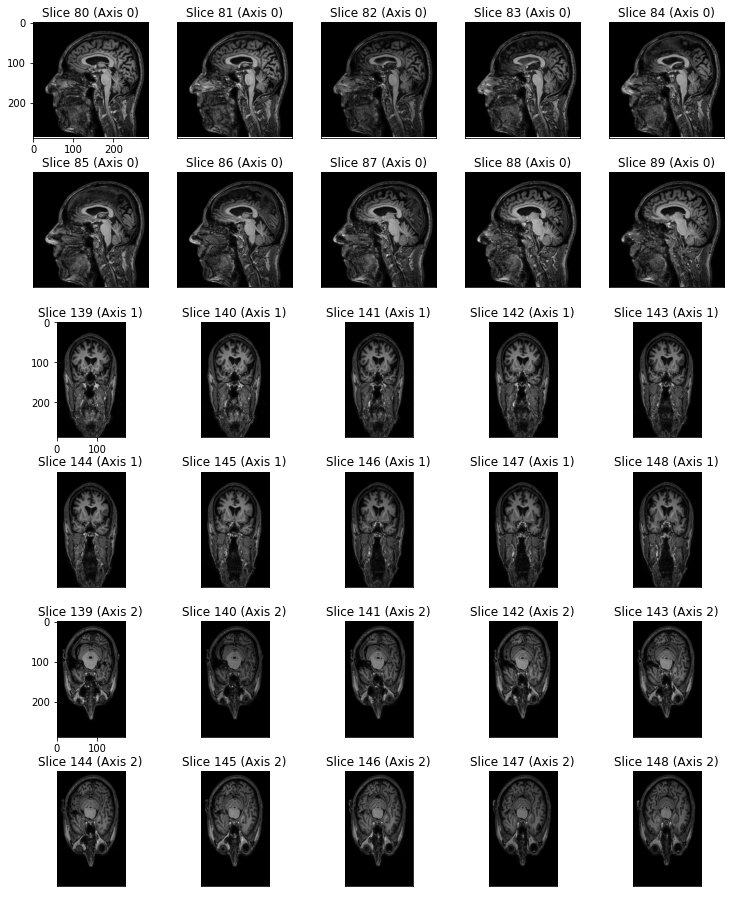

In [111]:
# Re-orient
if len(ext) == 1 and ".dcm" in ext:
    viz_fn(fnames[0], do_dcm = True, do_reorient=True)
else:
    viz_fn(nii[0], do_reorient=False)